In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mlflow
import mlflow.sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
import boto3
from io import BytesIO
import datetime

In [2]:
class ModelWithScaler(mlflow.pyfunc.PythonModel):
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def predict(self, context, model_input):
        # Scale the input using the scaler
        input_scaled = self.scaler.transform(model_input)
        return self.model.predict(input_scaled)

c:\Users\ursal\Desktop\notebooks_licenta\.venv\Lib\site-packages\mlflow\pyfunc\utils\data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [3]:
minio_endpoint = "http://localhost:9000"  # minio:9000 - in the pipeline careful
access_key = "IFSYL3fy8jSmMfK2To6G"
secret_key = "WzhnEeyrtGmjtxE5QtSzK7ka0fZhgAgnqoykxm5g"
bucket_name = "datasets-mlops"

s3 = boto3.client('s3',
                  endpoint_url=minio_endpoint,
                  aws_access_key_id=access_key,
                  aws_secret_access_key=secret_key)


In [4]:
# WE GET THE INITIAL / HISTORICAL DATASET WHICH IS 2015-2019 # IN TRUTH ITS 2015-2020 BUT WE DELIMITATE THIS.
obj = s3.get_object(Bucket=bucket_name, Key="historical/historical_dataset.csv" )
df = pd.read_csv(BytesIO(obj['Body'].read()))

df = df[df['year']<2020]
df

,year,month,day,hour,DE_wind_generation_actual,DE_wind_capacity,DE_wind_speed,DE_temperature,DE_air_density
0,2015,1,1,0,8852.0,27913.0,2.307,-0.895,1.275
1,2015,1,1,1,9054.0,27913.0,2.347,-0.971,1.276
2,2015,1,1,2,9070.0,27913.0,2.394,-1.041,1.276
3,2015,1,1,3,9163.0,27913.0,2.396,-1.097,1.277
4,2015,1,1,4,9231.0,27913.0,2.420,-1.153,1.277
...,...,...,...,...,...,...,...,...,...
43819,2019,12,31,19,8875.0,50452.0,1.808,0.751,1.265
43820,2019,12,31,20,7652.0,50452.0,1.828,0.651,1.267
43821,2019,12,31,21,7283.0,50452.0,1.850,0.501,1.269
43822,2019,12,31,22,6573.0,50452.0,1.814,0.297,1.270


In [5]:
df['lag_1'] = df['DE_wind_generation_actual'].shift(1)
df['lag_2'] = df['DE_wind_generation_actual'].shift(2)
df['lag_3'] = df['DE_wind_generation_actual'].shift(3)
df.dropna(inplace=True)

In [6]:
df

,year,month,day,hour,DE_wind_generation_actual,DE_wind_capacity,DE_wind_speed,DE_temperature,DE_air_density,lag_1,lag_2,lag_3
3,2015,1,1,3,9163.0,27913.0,2.396,-1.097,1.277,9070.0,9054.0,8852.0
4,2015,1,1,4,9231.0,27913.0,2.420,-1.153,1.277,9163.0,9070.0,9054.0
5,2015,1,1,5,9689.0,27913.0,2.405,-1.234,1.277,9231.0,9163.0,9070.0
6,2015,1,1,6,10331.0,27913.0,2.425,-1.397,1.278,9689.0,9231.0,9163.0
7,2015,1,1,7,10208.0,27913.0,2.515,-1.564,1.279,10331.0,9689.0,9231.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2019,12,31,19,8875.0,50452.0,1.808,0.751,1.265,9702.0,10293.0,10928.0
43820,2019,12,31,20,7652.0,50452.0,1.828,0.651,1.267,8875.0,9702.0,10293.0
43821,2019,12,31,21,7283.0,50452.0,1.850,0.501,1.269,7652.0,8875.0,9702.0
43822,2019,12,31,22,6573.0,50452.0,1.814,0.297,1.270,7283.0,7652.0,8875.0


In [7]:
# logic when no batches.
try:
    obj_latest = s3.get_object(Bucket=bucket_name, Key="historical/latest_batches.csv")
    df_latest_batches = pd.read_csv(BytesIO(obj_latest['Body'].read()))

    split_idx = int(len(df_latest_batches) * 0.7)
    df_latest_train = df_latest_batches.iloc[:split_idx]
    df_latest_test = df_latest_batches[split_idx:]

    train_df = pd.concat([df, df_latest_train], ignore_index=True)
    test_df = df_latest_test.reset_index(drop=True)

    print("Using historical + batch data.")

except s3.exceptions.NoSuchKey:
    print("No batch file found, using historical data only.")

    split_idx = int(len(df) * 0.7)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:].reset_index(drop=True)


No batch file found, using historical data only.


In [10]:
# # WE GET THE LATEST BATCHES
# obj_latest = s3.get_object(Bucket=bucket_name, Key="historical/latest_batches.csv" )

# df_latest_batches = pd.read_csv(BytesIO(obj_latest['Body'].read()))

# print(df_latest_batches)

In [11]:
# split_idx = int(len(df_latest_batches) * 0.7)
# df_latest_train = df_latest_batches.iloc[:split_idx]
# df_latest_test = df_latest_batches[split_idx:]

In [12]:
# train_df = pd.concat([df,df_latest_train],ignore_index=True)
# test_df = df_latest_test.reset_index(drop = True)

In [13]:
print("train_df")
print(train_df)

train_df
       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
3      2015      1    1     3                     9163.0           27913.0   
4      2015      1    1     4                     9231.0           27913.0   
5      2015      1    1     5                     9689.0           27913.0   
6      2015      1    1     6                    10331.0           27913.0   
7      2015      1    1     7                    10208.0           27913.0   
...     ...    ...  ...   ...                        ...               ...   
30672  2018      7    2     0                    12332.0           46073.0   
30673  2018      7    2     1                    10825.0           46073.0   
30674  2018      7    2     2                     9630.0           46073.0   
30675  2018      7    2     3                     8520.0           46073.0   
30676  2018      7    2     4                     6899.0           46073.0   

       DE_wind_speed  DE_temperature  DE_air_density  

In [14]:
print("test_df")
print(test_df)

test_df
       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
0      2018      7    2     5                     4248.0           46073.0   
1      2018      7    2     6                     2480.0           46073.0   
2      2018      7    2     7                     2409.0           46073.0   
3      2018      7    2     8                     3263.0           46073.0   
4      2018      7    2     9                     4091.0           46073.0   
...     ...    ...  ...   ...                        ...               ...   
13142  2019     12   31    19                     8875.0           50452.0   
13143  2019     12   31    20                     7652.0           50452.0   
13144  2019     12   31    21                     7283.0           50452.0   
13145  2019     12   31    22                     6573.0           50452.0   
13146  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density   

In [15]:
print("train_df shape:", train_df.shape)
print("test_df shape after dropna:", test_df.shape)

train_df shape: (30674, 12)
test_df shape after dropna: (13147, 12)


In [16]:
features = ['DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density','lag_1','lag_2','lag_3']
target = 'DE_wind_generation_actual'

In [17]:
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [20]:

# Define parameter grid
param_grid = {
    'C': [0.01,0.1, 1, 5, 10,100,200],  # Regularization strength
    'epsilon': [0.00001,0.0001,0.001,0.01, 0.1, 1],  # Tolerance for error
    'max_iter': [1000, 5000, 10000, 50000]  # Increase iterations for convergence
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LinearSVR(dual='auto'), param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Train
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_svr = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 168 candidates, totalling 504 fits
Best parameters: {'C': 200, 'epsilon': 0.0001, 'max_iter': 10000}


In [21]:
coefficients = pd.DataFrame(best_svr.coef_, index=features, columns=['Coefficient'])
print("\nFeature Coefficients:")
print(coefficients.sort_values('Coefficient', ascending=False))


Feature Coefficients:
                   Coefficient
lag_1             14760.011331
lag_3              1109.773792
DE_wind_speed        92.004242
DE_wind_capacity     22.881427
DE_air_density      -64.854266
DE_temperature      -69.767041
lag_2             -7990.154964


In [22]:
y_pred = best_svr.predict(X_test_scaled)
test_df['predicted_wind_generation'] = y_pred

In [23]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Compute R² Score
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 390038.5411
Root Mean Squared Error (RMSE): 624.5307
R² Score: 0.9958


In [24]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Percentage': (abs(y_test - y_pred)/y_test) * 100
})
results_df.describe()

,Actual,Predicted,Error,Percentage
count,13147.000000,13147.000000,13147.000000,13147.000000
mean,13471.637864,13451.075809,20.562055,4.945442
std,9690.471020,9667.863692,624.215813,6.052988
min,333.000000,-6.260510,-4233.747018,0.000642
25%,5958.500000,5975.891758,-317.438547,1.377197
50%,10832.000000,10857.015377,-4.953392,3.111227
75%,18686.500000,18707.539011,332.604525,6.252096
max,45085.000000,45659.643296,4416.725866,100.785509


In [25]:
print(results_df[results_df['Percentage'] > 100])

      Actual  Predicted      Error  Percentage
7035   797.0   -6.26051  803.26051  100.785509


In [26]:
test_df

,year,month,day,hour,DE_wind_generation_actual,DE_wind_capacity,DE_wind_speed,DE_temperature,DE_air_density,lag_1,lag_2,lag_3,predicted_wind_generation
0,2018,7,2,5,4248.0,46073.0,2.253,13.401,1.200,6899.0,8520.0,9630.0,5692.428390
1,2018,7,2,6,2480.0,46073.0,2.518,16.275,1.190,4248.0,6899.0,8520.0,2285.419985
2,2018,7,2,7,2409.0,46073.0,2.752,18.443,1.183,2480.0,4248.0,6899.0,1458.228374
3,2018,7,2,8,3263.0,46073.0,2.849,19.901,1.178,2409.0,2480.0,4248.0,2725.548627
4,2018,7,2,9,4091.0,46073.0,2.887,21.109,1.174,3263.0,2409.0,2480.0,4123.041220
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13142,2019,12,31,19,8875.0,50452.0,1.808,0.751,1.265,9702.0,10293.0,10928.0,9247.151601
13143,2019,12,31,20,7652.0,50452.0,1.828,0.651,1.267,8875.0,9702.0,10293.0,8224.478091
13144,2019,12,31,21,7283.0,50452.0,1.850,0.501,1.269,7652.0,8875.0,9702.0,6714.659056
13145,2019,12,31,22,6573.0,50452.0,1.814,0.297,1.270,7283.0,7652.0,8875.0,7137.147631


In [27]:
start_date = test_df.iloc[0][['year','month','day']].values
end_date = test_df.iloc[-1][['year','month','day']].values

start_date_str = f"{int(start_date[0]):04d}-{int(start_date[1]):02d}-{int(start_date[2]):02d}"
end_date_str = f"{int(end_date[0]):04d}-{int(end_date[1]):02d}-{int(end_date[2]):02d}"

print(f'Linear SVR: Wind Generation Prediction {start_date_str} - {end_date_str}')


Linear SVR: Wind Generation Prediction 2018-07-02 - 2019-12-31


In [28]:
subset = test_df[(test_df['year'] == start_date[0]) &
                 (test_df['month'] == start_date[1]) &
                 (test_df['day'] >=start_date[2]) & (test_df['day']<=end_date[2])]

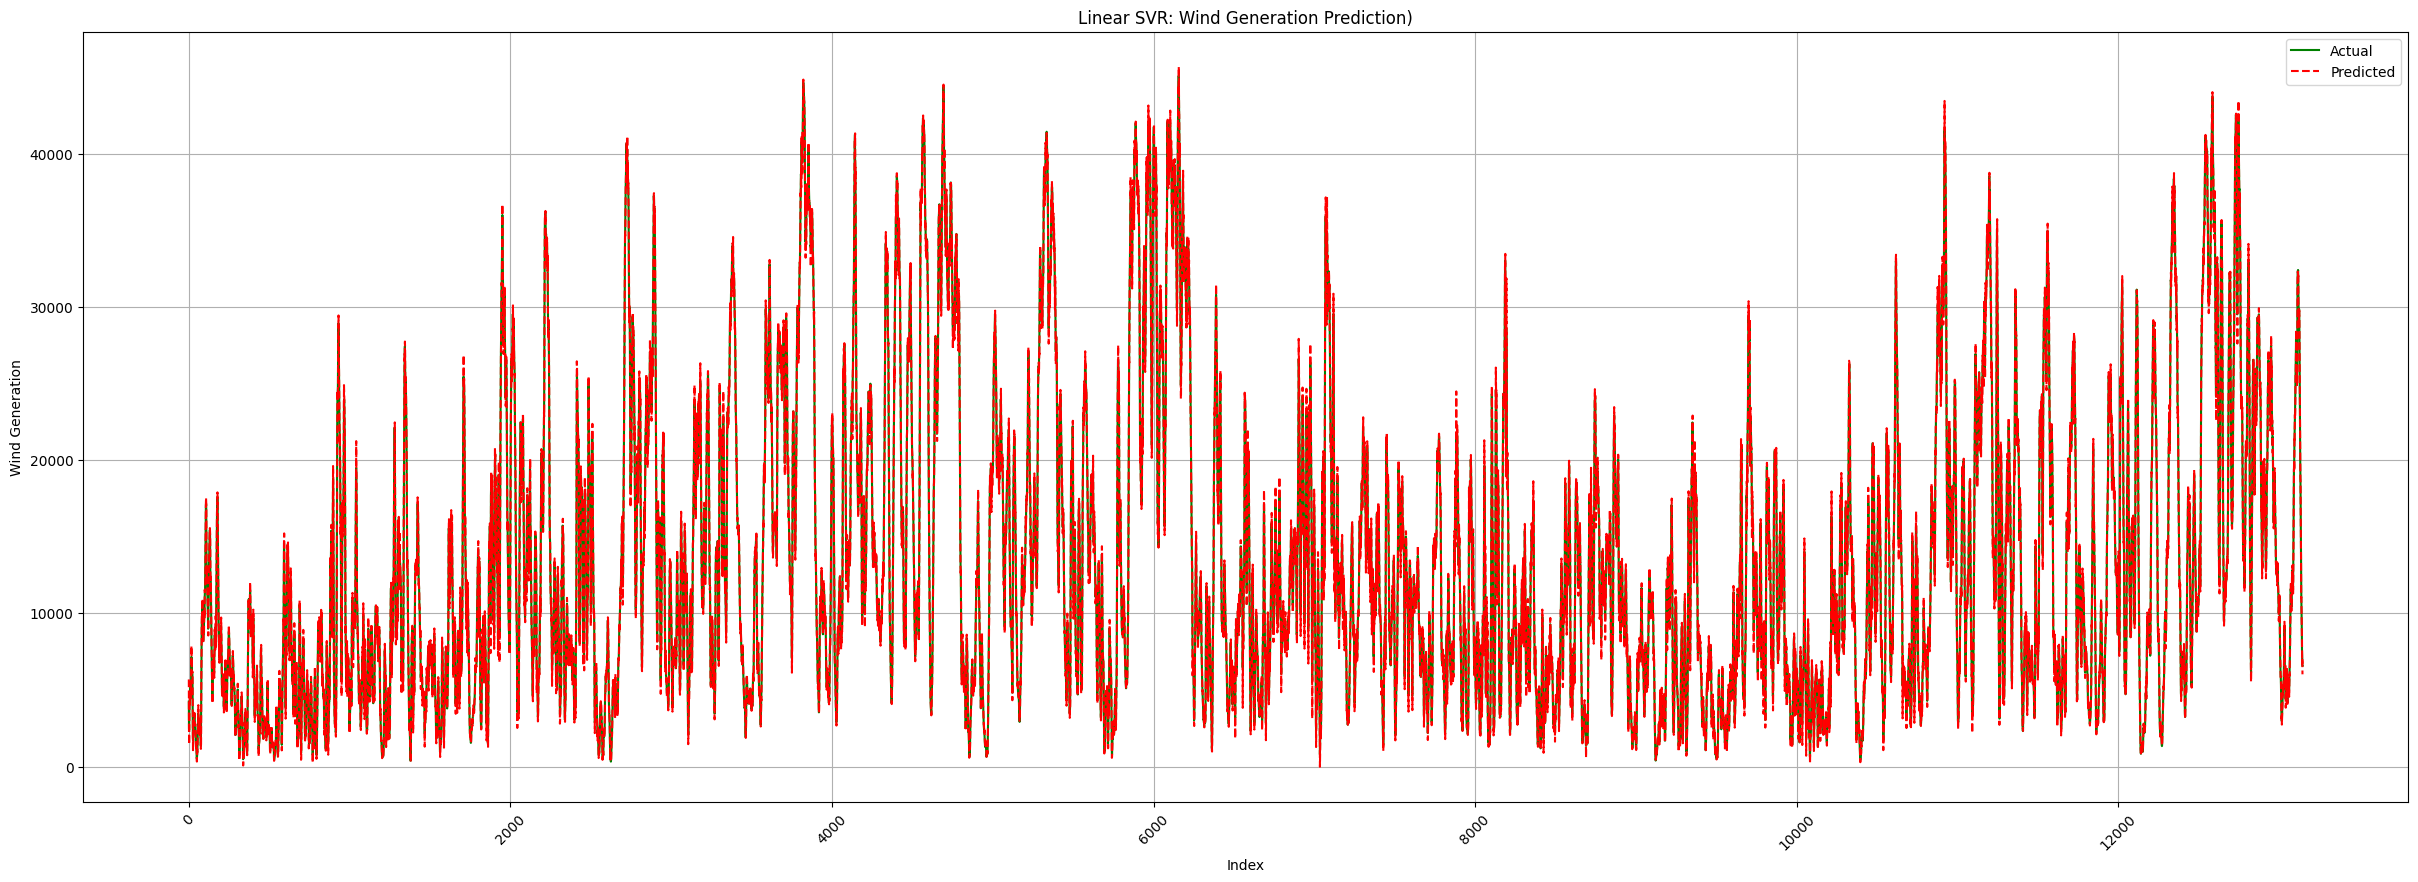

In [29]:
plt.figure(figsize=(30, 10))
plt.plot(test_df.index, test_df['DE_wind_generation_actual'], label="Actual", color="green")
plt.plot(test_df.index, test_df['predicted_wind_generation'], label="Predicted", color="red", linestyle="dashed")
plt.title('Linear SVR: Wind Generation Prediction)')
plt.xlabel('Index')
plt.ylabel('Wind Generation')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

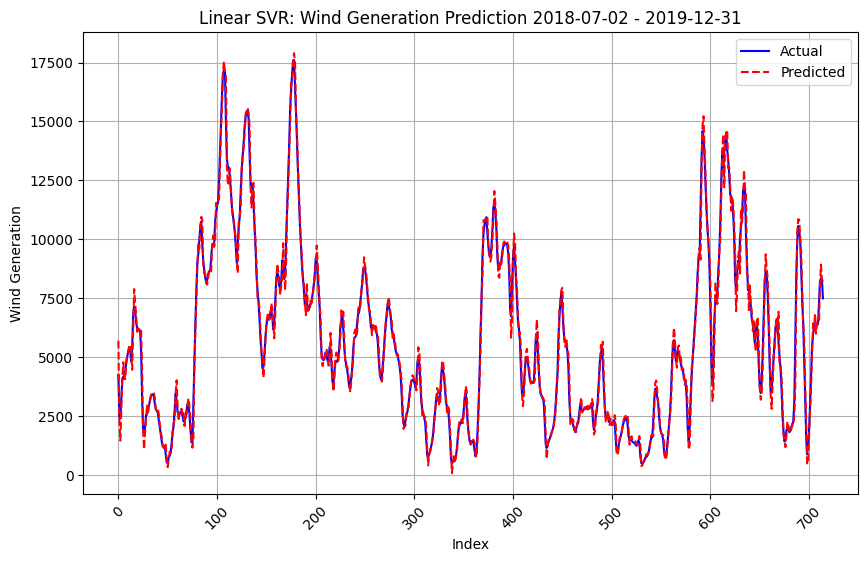

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(subset.index, subset['DE_wind_generation_actual'], label="Actual", color="blue")
plt.plot(subset.index, subset['predicted_wind_generation'], label="Predicted", color="red", linestyle="dashed")
plt.title(f'Linear SVR: Wind Generation Prediction {start_date_str} - {end_date_str}')
plt.xlabel('Index')
plt.ylabel('Wind Generation')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [31]:
date = datetime.datetime.now()
ver = date.strftime("%Y-%m-%d-%H:%M")
ver

'2025-04-24-00:36'

In [43]:
import json
import os

features_ = ['DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density']

seasonal_stats = {}

for (year, month), group in df.groupby(["year", "month"]):
    stats = group[features_].describe().to_dict()  # includes count, mean, std, min, 25%, 50%, 75%, max
    
    # Convert year to string for consistency
    year_str = str(year)
    
    # Ensure the year (as a string) exists in seasonal_stats
    if year_str not in seasonal_stats:
        seasonal_stats[year_str] = {}
    
    # Store the stats using the zero-padded month as the key
    seasonal_stats[year_str][str(month).zfill(2)] = stats

# Now serialize to JSON
js = json.dumps(seasonal_stats, indent=4)
with open("../jsons/seasonal_stats.json", "w") as f:
    f.write(js)

In [ ]:

df_dummy = df.copy()
features_ = ['DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density']
stats = train_df[features_].describe(percentiles=[.25,.5,.75]).transpose()
stats.to_json("training_feature_stats.json", indent=4)




In [ ]:
# mlflow.set_tracking_uri('http://localhost:5000')
# mlflow.set_experiment("LinearSVR Wind Generation Prediction-Batches-1")
# print("setup complete")
# with mlflow.start_run(run_name=f"linearsvr_model-{ver}"):
#     print("started run")

#     mlflow.sklearn.pyfunc.log_model("linearSVR_withScaler",python_model=ModelWithScaler(model = best_svr, scaler= scaler))
#     print("logged model")

#     mlflow.log_params(best_svr.get_params())
#     print("logged params")

#     mlflow.log_metric("RMSE",rmse)
#     print("logged RMSE")
#     mlflow.log_metric("R2",r2)
#     print("logged R2")
    
#     mlflow.log_artifact("training_feature_stats.json")

#     model_signature = mlflow.models.infer_signature(X_test,y_pred)
#     model_info = mlflow.register_model(
#         "runs:/{}/linearSVR_withScaler_Batches".format(mlflow.active_run().info.run_id),
#         name="model_linearSVR_scaler_Batches"
#     )
#     print("model logged with mlflow")

# os.remove("training_feature_stats.json")

2025/04/21 13:31:26 INFO mlflow.tracking.fluent: Experiment with name 'LinearSVR Wind Generation Prediction-Batches-1' does not exist. Creating a new experiment.


setup complete
started run


2025/04/21 13:31:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logged model
logged params
logged RMSE
logged R2


Successfully registered model 'model_linearSVR_scaler_Batches'.
2025/04/21 13:31:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_linearSVR_scaler_Batches, version 1


model logged with mlflow
🏃 View run linearsvr_model-2025-04-21-13:31 at: http://localhost:5000/#/experiments/2/runs/647ff7fa72ab4d9ead197bd49d3ba083
🧪 View experiment at: http://localhost:5000/#/experiments/2


Created version '1' of model 'model_linearSVR_scaler_Batches'.


# CHESTII PE CARE LE AM TESTAT ULTERIOR:

## lag vs non lag vs norma;

In [ ]:
# --- Model with only Lags ---
lag_features = ['lag_1', 'lag_2', 'lag_3']
X_train_lags = train_df[lag_features]
X_test_lags = test_df[lag_features]

# Scale lag features separately (or use the relevant columns from the original scaling)
scaler_lags = StandardScaler()
X_train_lags_scaled = scaler_lags.fit_transform(X_train_lags)
X_test_lags_scaled = scaler_lags.transform(X_test_lags)

# Retrain or use the same grid search structure if desired
# For simplicity, let's use the best params found earlier
svr_lags = GridSearchCV(LinearSVR(dual='auto'), param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1) # Use found params
svr_lags.fit(X_train_lags_scaled, y_train)
y_pred_lags = svr_lags.predict(X_test_lags_scaled)
rmse_lags = np.sqrt(mean_squared_error(y_test, y_pred_lags))
r2_lags = r2_score(y_test, y_pred_lags)
print(f"\n--- Model with ONLY Lag Features ---")
print(f"RMSE: {rmse_lags:.4f}")
print(f"R² Score: {r2_lags:.4f}")

# --- Model with only Non-Lag Features ---
non_lag_features = ['DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density']
X_train_nonlags = train_df[non_lag_features]
X_test_nonlags = test_df[non_lag_features]

scaler_nonlags = StandardScaler()
X_train_nonlags_scaled = scaler_nonlags.fit_transform(X_train_nonlags)
X_test_nonlags_scaled = scaler_nonlags.transform(X_test_nonlags)

svr_nonlags = GridSearchCV(LinearSVR(dual='auto'), param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1) # Use found params
svr_nonlags.fit(X_train_nonlags_scaled, y_train)
y_pred_nonlags = svr_nonlags.predict(X_test_nonlags_scaled)
rmse_nonlags = np.sqrt(mean_squared_error(y_test, y_pred_nonlags))
r2_nonlags = r2_score(y_test, y_pred_nonlags)
print(f"\n--- Model with ONLY Non-Lag Features ---")
print(f"RMSE: {rmse_nonlags:.4f}")
print(f"R² Score: {r2_nonlags:.4f}")

print(f"\n--- Original Model (All Features) ---")
print(f"RMSE: {rmse:.4f}") # Original RMSE calculated earlier
print(f"R² Score: {r2:.4f}") # Original R2 calculated earlier

Fitting 3 folds for each of 168 candidates, totalling 504 fits

--- Model with ONLY Lag Features ---
RMSE: 684.4421
R² Score: 0.9956
Fitting 3 folds for each of 168 candidates, totalling 504 fits

--- Model with ONLY Non-Lag Features ---
RMSE: 5186.5441
R² Score: 0.7500

--- Original Model (All Features) ---
RMSE: 677.5350
R² Score: 0.9957


## corr matrix si coeff features

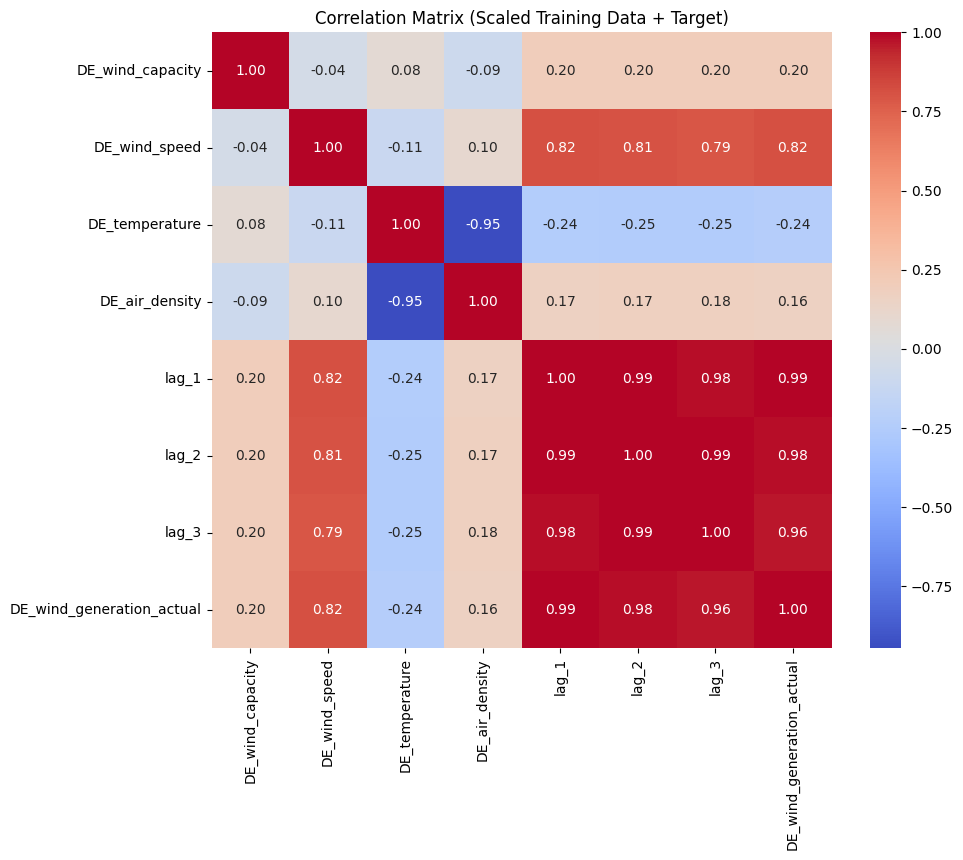


Correlations with Target:
DE_wind_generation_actual    1.000000
lag_1                        0.994677
lag_2                        0.981208
lag_3                        0.962598
DE_wind_speed                0.817570
DE_wind_capacity             0.199651
DE_air_density               0.164643
DE_temperature              -0.238747
Name: DE_wind_generation_actual, dtype: float64


In [ ]:
# Add target back to X_train_scaled for correlation calculation
train_data_for_corr = pd.DataFrame(X_train_scaled, columns=features)
train_data_for_corr[target] = y_train.values # Use .values to avoid index alignment issues if indices differ

plt.figure(figsize=(10, 8))
sns.heatmap(train_data_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Scaled Training Data + Target)')
plt.show()

print("\nCorrelations with Target:")
print(train_data_for_corr.corr()[target].sort_values(ascending=False))

## Residuals plot

In [38]:
test_df['residual'] = test_df['DE_wind_generation_actual'] - test_df['predicted_wind_generation']

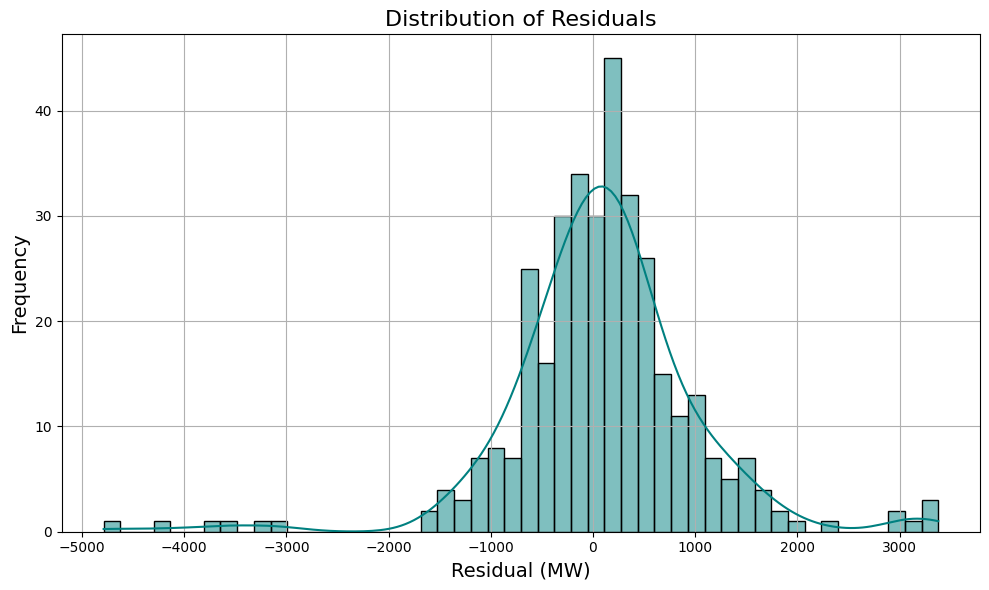

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(test_df['residual'], bins=50, kde=True, color='teal')
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residual (MW)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


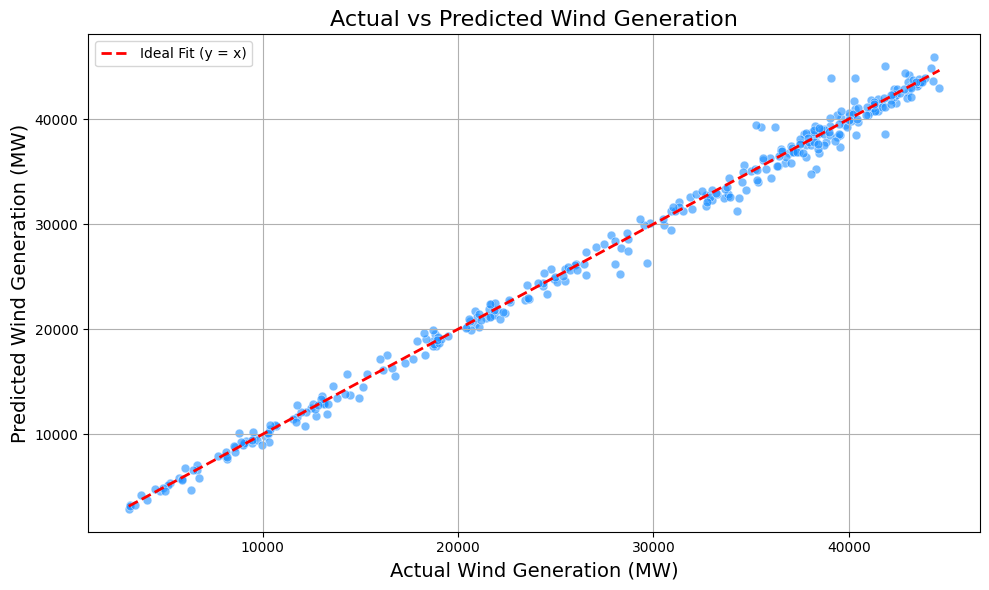

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_df['DE_wind_generation_actual'], y=test_df['predicted_wind_generation'], color='dodgerblue', s=40, alpha=0.6)
plt.plot([test_df['DE_wind_generation_actual'].min(), test_df['DE_wind_generation_actual'].max()],
         [test_df['DE_wind_generation_actual'].min(), test_df['DE_wind_generation_actual'].max()],
         color='red', linestyle='--', linewidth=2, label='Ideal Fit (y = x)')
plt.title('Actual vs Predicted Wind Generation', fontsize=16)
plt.xlabel('Actual Wind Generation (MW)', fontsize=14)
plt.ylabel('Predicted Wind Generation (MW)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


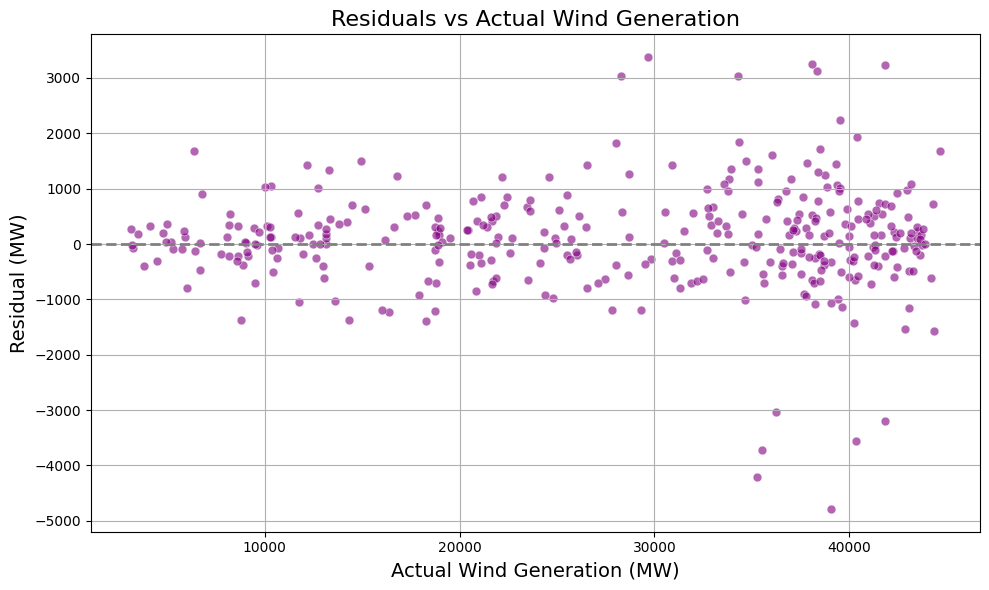

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_df['DE_wind_generation_actual'], y=test_df['residual'], color='purple', s=40, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=2)
plt.title('Residuals vs Actual Wind Generation', fontsize=16)
plt.xlabel('Actual Wind Generation (MW)', fontsize=14)
plt.ylabel('Residual (MW)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


## feature importance

C:\Users\ursal\AppData\Local\Temp\ipykernel_21064\3761066473.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_importance.values, y=coef_importance.index, palette='viridis')


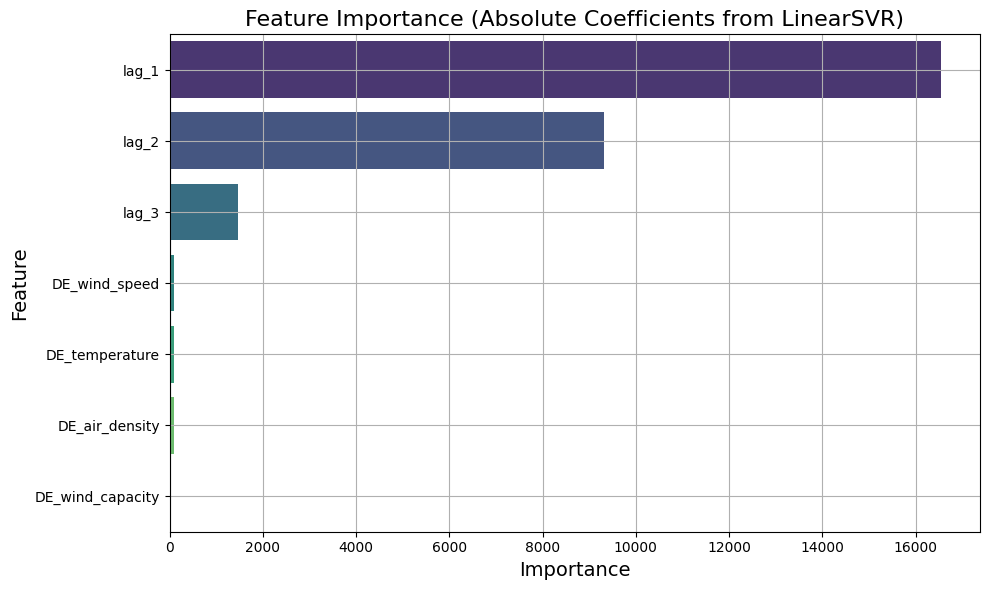

In [43]:
coef_importance = pd.Series(np.abs(best_svr.coef_), index=features)
coef_importance = coef_importance.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=coef_importance.values, y=coef_importance.index, palette='viridis')
plt.title('Feature Importance (Absolute Coefficients from LinearSVR)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ursal\AppData\Local\Temp\ipykernel_21064\1289160441.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='magma')


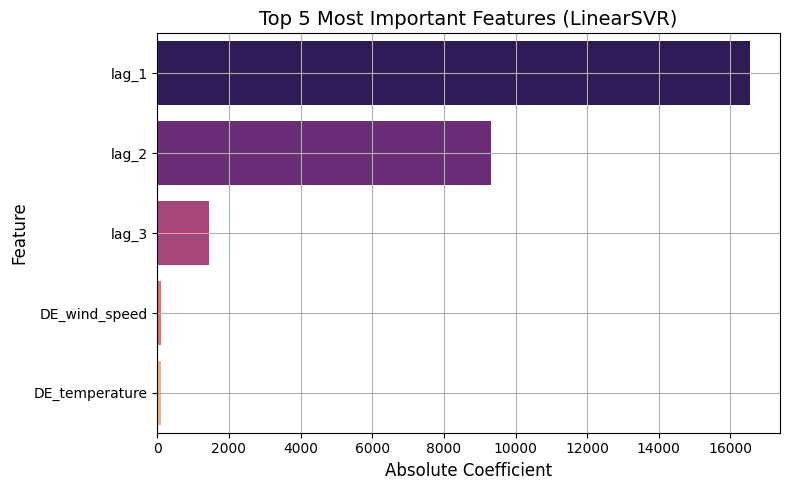

In [44]:
# Show only top 5 important features
top_n = 5
top_features = coef_importance.head(top_n)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index, palette='magma')
plt.title(f'Top {top_n} Most Important Features (LinearSVR)', fontsize=14)
plt.xlabel('Absolute Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
